# Pre-process SPC strom reports

In [1]:
import sys
from glob import glob

import h5py
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
import geopy.distance

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import preprocess_utils as pu

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import importlib
importlib.reload(du)

<module 'data_utils' from '/glade/u/home/ksha/NCAR/libs/data_utils.py'>

### Domain info

In [6]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_80km'][...]
    lat_72km = h5io['lat_80km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]

In [7]:
preserve_inds = [4, 5, 6, 10, 15, 16]
column_names = ['date', 'time', 'tz', 'mag', 'slat', 'slon']

In [8]:
year = 2010
file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]
df_torn = pd.read_csv(file_torn)
df_torn = df_torn.iloc[:, preserve_inds]
df_torn.columns = column_names

file_wind = sorted(glob(report_dir+'{}_wind.csv'.format(year)))[0]
df_wind = pd.read_csv(file_wind)
df_wind = df_wind.iloc[:, preserve_inds]
df_wind.columns = column_names

file_hail = sorted(glob(report_dir+'{}_hail.csv'.format(year)))[0]
df_hail = pd.read_csv(file_hail)
df_hail = df_hail.iloc[:, preserve_inds]
df_hail.columns = column_names

In [9]:
from functools import reduce

In [10]:
data_frames = [df_torn, df_wind, df_hail]

In [11]:
df_merged = reduce(lambda  left,right: pd.merge(left, right, how='outer'), data_frames)

/glade/scratch/ksha/ipykernel_209521/1414804474.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_merged = reduce(lambda  left,right: pd.merge(left, right, how='outer'), data_frames)


In [12]:
#df_merged

In [13]:
base_ref = datetime(2019, 10, 1)
date_list_v4x = [base_ref + timedelta(days=day) for day in range(429)]

In [25]:
date_list_v4x[157]

datetime.datetime(2020, 3, 6, 0, 0)

**Merged version of all hazards**

In [15]:
from scipy.spatial import cKDTree

In [16]:
gridTree = cKDTree(list(zip(lon_72km.ravel(), lat_72km.ravel()))) #KDTree_wraper(xgrid, ygrid)
grid_shape = lon_72km.shape

In [17]:
def dist_earth(lat1, lon1, lat2, lon2):

    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [18]:
def search_radi(lon, lat, stn_lon, stn_lat):
    dist, indexes = gridTree.query(list(zip(np.array(stn_lon), np.array(stn_lat))))
    indx_all, indy_all = np.unravel_index(indexes, grid_shape)
    L = len(stn_lon)
    
    indx_out = np.empty([L, 10])
    indy_out = np.empty([L, 10])
    
    indx_out[...] = np.nan
    indy_out[...] = np.nan
    
    gap = 2
    
    for l in range(L):

        indx = indx_all[l]
        indy = indy_all[l]
        
        indx_l = []
        indy_l = []
        
        indx_left = np.max([indx-gap, 0])
        indy_bot = np.max([indy-gap, 0])
    
        lon_sub = lon[indx_left:indx+gap, indy_bot:indy+gap]
        lat_sub = lat[indx_left:indx+gap, indy_bot:indy+gap]
    
        shape_sub = lon_sub.shape
    
        for xi in range(shape_sub[0]):
            for yj in range(shape_sub[1]):
                
                lon_temp = lon_sub[xi, yj]
                lat_temp = lat_sub[xi, yj]
                
                coords_1 = (lat_temp, lon_temp,)
                coords_2 = (stn_lat[l], stn_lon[l])
                
                dist_km = geopy.distance.geodesic(coords_2, coords_1).km
                
                if dist_km < 40:
                    indx_l.append(indx_left+xi)
                    indy_l.append(indy_bot+yj)
        
        count = len(indx_l)
        indx_out[l, :count] = np.array(indx_l)
        indy_out[l, :count] = np.array(indy_l)
        
    return indx_out, indy_out

In [19]:
preserve_inds = [4, 5, 6, 15, 16]
column_names = ['date', 'time', 'tz', 'slat', 'slon']

# ['date', 'time', 'tz', 'slat', 'slon']

L_v3 = len(date_list_v4x)
#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
for lead in [22, 23]:
    
    torn_grid_v3 = np.empty((L_v3,)+lon_72km.shape+(3,))

    print('========== Processing lead time = {} =========='.format(lead))

    record_v3 = np.empty((L_v3, 3*30))
    record_v3[...] = np.nan

    for y in range(2010, 2022):
        
        #temp_day_old = 9999
        
        # Year info
        year_int = int(y)
        year = str(year_int)

        # Raw tornado files
        file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]
        file_wind = sorted(glob(report_dir+'{}_wind.csv'.format(year)))[0]
        file_hail = sorted(glob(report_dir+'{}_hail.csv'.format(year)))[0]
        
        # import csv to pandas and then np.array
        df_torn = pd.read_csv(file_torn)
        df_torn = df_torn.iloc[:, preserve_inds]
        df_torn.columns = column_names
        
        df_wind = pd.read_csv(file_wind)
        df_wind = df_wind.iloc[:, preserve_inds]
        df_wind.columns = column_names
        
        df_hail = pd.read_csv(file_hail)
        df_hail = df_hail.iloc[:, preserve_inds]
        df_hail.columns = column_names
        
        data_frames = [df_torn, df_wind, df_hail]
        #df_merged = reduce(lambda  left,right: pd.merge(left, right, how='outer'), data_frames)
        
        for c, df in enumerate(data_frames):
        
            temp_array = df.values

            # datetime and timezone processing
            L = len(temp_array)
            temp_tz = temp_array[:, 2]
            temp_dt_list = []
            flag_badboy = False

            for i in range(L):
                try:
                    # the string can be converted to datetime object
                    temp_localtime = datetime.strptime(temp_array[i, 0]+'|'+temp_array[i, 1], '%Y-%m-%d|%H:%M:%S')
                    flag_badboy = False
                except:
                    # the string cannot be converted; typically a "?"
                    temp_localtime = np.nan
                    flag_badboy = True

                # adjust timezones to UTC/GMT 
                if flag_badboy is False:
                    temp_tz = temp_array[i, 2]
                    if temp_tz == 3:
                        temp_localtime = temp_localtime + timedelta(hours=6) # <--- !!! "3" means CST
                    elif temp_tz == 9:
                        temp_localtime = temp_localtime # "9" means GMT
                    else:
                        temp_localtime = np.nan # otherwise doint know

                temp_dt_list.append(temp_localtime)

            # Insert in-situ reports into hourly, gridded data frames    
            ## convert slat slon to domain indices

            slon = temp_array[:, 4]
            slat = temp_array[:, 3]

            flag_pick = np.logical_and(slon<-20, slat>5)

            slon = slon[flag_pick]
            slat = slat[flag_pick]

            L = len(slon)
        
            if L > 0:
            
                dist, indexes = gridTree.query(list(zip(np.array(slon), np.array(slat))))
                indx, indy = np.unravel_index(indexes, grid_shape)
                
                indx_dist, indy_dist = search_radi(lon_72km, lat_72km, np.array(slon), np.array(slat))
                
                for i in range(L):

                    # the time of a single record
                    temp_datetime = temp_dt_list[i]
                    temp_day = temp_datetime.day
                    temp_hour = temp_datetime.hour

                    temp_datetime_day = datetime(temp_datetime.year, temp_datetime.month, temp_day)
                    
                    if temp_hour == lead:

                        diff_days = (temp_datetime_day - base_ref).days
                        if (diff_days > 0) and (diff_days < L_v3):
                            # how many positives within a 3-by-3 box (self + 9 grids = 10)
                            N = 10 - np.sum(np.isnan(indx_dist[i, :]))
                            if N == 0:
                                torn_grid_v3[diff_days, indx[i], indy[i], c] = 1.0
                            else:
                                for ni in range(N):
                                    torn_grid_v3[diff_days, int(indx_dist[i, ni]), int(indy_dist[i, ni]), c] = 1.0
                                    
                    else:
                        continue

    tuple_save = (torn_grid_v3,)
    label_save = ['record_v4x',]
    du.save_hdf5(tuple_save, label_save, save_dir_scratch, 'SPC_to_lead{}_72km_v4x.hdf'.format(lead))

========== Processing lead time = 18 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead18_72km_v4x.hdf
========== Processing lead time = 19 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead19_72km_v4x.hdf
========== Processing lead time = 20 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead20_72km_v4x.hdf
========== Processing lead time = 21 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead21_72km_v4x.hdf
========== Processing lead time = 22 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead22_72km_v4x.hdf
========== Processing lead time = 23 ==========
Save to /glade/scratch/ksha/DRIVE/SPC_to_lead23_72km_v4x.hdf


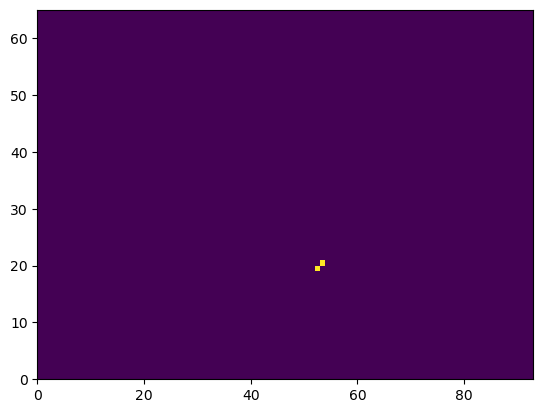

In [20]:
plt.pcolormesh(np.sum(torn_grid_v3[:3, ..., 1], axis=0))

In [136]:
def neighbour_leads(lead):
    out = [lead-2, lead-1, lead, lead+1]
    flag_shift = [0, 0, 0, 0]
    
    for i in range(4):
        if out[i] < 0:
            out[i] = 24+out[i]
            flag_shift[i] = -1
        if out[i] > 23:
            out[i] = out[i]-24
            flag_shift[i] = +1
            
    return out, flag_shift

In [165]:
lead = 4

lead_window, flag_shift = neighbour_leads(lead)

record_all = ()

for i, lead_temp in enumerate(lead_window):
    
    flag_ = flag_shift[i]
    
    with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
        record_temp = h5io['record_v3'][...]
        
    if flag_shift[i] == 0:
        record_all = record_all + (record_temp,)
        
    if flag_shift[i] == -1:
        record_temp[1:, ...] = record_temp[:-1, ...]
        record_temp[0, ...] = np.nan
        record_all = record_all + (record_temp,)
    
    if flag_shift[i] == +1:
        record_temp[:-1, ...] = record_temp[1:, ...]
        record_temp[-1, ...] = np.nan
        record_all = record_all + (record_temp,)


shape_record = record_temp.shape      
record_v3 = np.empty(shape_record)
record_v3[...] = np.nan

for i in range(4):
    record_temp = record_all[i]
    for day in range(shape_record[0]):
        for ix in range(shape_record[1]):
            for iy in range(shape_record[2]):
                for event in range(shape_record[3]):
                    if record_temp[day, ix, iy, event] > 0:
                        record_v3[day, ix, iy, event] = 1.0
                    elif record_v3[day, ix, iy, event] == 1.0:
                        record_v3[day, ix, iy, event] = 1.0
                    else:
                        record_v3[day, ix, iy, event] = 0.0

In [166]:
np.sum(record_v3)

4283.0

In [171]:
lead = 4

lead_window, flag_shift = neighbour_leads(lead)

record_all = ()

for i, lead_temp in enumerate(lead_window):
    
    flag_ = flag_shift[i]
    
    with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all_old.hdf'.format(lead_temp), 'r') as h5io:
        record_temp = h5io['record_v3'][...]
        
    if flag_shift[i] == 0:
        record_all = record_all + (record_temp,)
        
    if flag_shift[i] == -1:
        record_temp[1:, ...] = record_temp[:-1, ...]
        record_temp[0, ...] = np.nan
        record_all = record_all + (record_temp,)
    
    if flag_shift[i] == +1:
        record_temp[:-1, ...] = record_temp[1:, ...]
        record_temp[-1, ...] = np.nan
        record_all = record_all + (record_temp,)


shape_record = record_temp.shape      
record_v3 = np.empty(shape_record)
record_v3[...] = np.nan

for i in range(4):
    record_temp = record_all[i]
    for day in range(shape_record[0]):
        for ix in range(shape_record[1]):
            for iy in range(shape_record[2]):
                for event in range(shape_record[3]):
                    if record_v3[day, ix, iy, event] == 1.0:
                        record_v3[day, ix, iy, event] = 1.0
                    elif record_temp[day, ix, iy, event] == 1.0:
                        record_v3[day, ix, iy, event] = 1.0
                    else:
                        record_v3[day, ix, iy, event] = 0.0

In [172]:
np.sum(record_v3[..., 1])

2641.0

In [168]:
np.sum(record_v3[..., 1])

2641.0

In [169]:
np.sum(record_v3)

4254.0

In [23]:
# preserve_inds = [4, 5, 6, 15, 16]
# column_names = ['date', 'time', 'tz', 'slat', 'slon']

# # ['date', 'time', 'tz', 'slat', 'slon']

# L_v3 = len(date_list_v3)
# L_v4 = len(date_list_v4)

# for lead in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:
    
#     torn_grid_v3 = np.empty((L_v3,)+lon_72km.shape+(3,))
#     torn_grid_v4 = np.empty((L_v4,)+lon_72km.shape+(3,))

#     print('========== Processing lead time = {} =========='.format(lead))

#     record_v3 = np.empty((L_v3, 3*30))*np.nan
#     record_v4 = np.empty((L_v3, 3*30))*np.nan

#     for y in range(2010, 2022):
        
#         #temp_day_old = 9999
        
#         # Year info
#         year_int = int(y)
#         year = str(year_int)

#         # Raw tornado files
#         file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]
#         file_wind = sorted(glob(report_dir+'{}_wind.csv'.format(year)))[0]
#         file_hail = sorted(glob(report_dir+'{}_hail.csv'.format(year)))[0]
        
#         # import csv to pandas and then np.array
#         df_torn = pd.read_csv(file_torn)
#         df_torn = df_torn.iloc[:, preserve_inds]
#         df_torn.columns = column_names
        
#         df_wind = pd.read_csv(file_wind)
#         df_wind = df_wind.iloc[:, preserve_inds]
#         df_wind.columns = column_names
        
#         df_hail = pd.read_csv(file_hail)
#         df_hail = df_hail.iloc[:, preserve_inds]
#         df_hail.columns = column_names
        
#         data_frames = [df_torn, df_wind, df_hail]
#         #df_merged = reduce(lambda  left,right: pd.merge(left, right, how='outer'), data_frames)
        
#         for c, df in enumerate(data_frames):
        
#             temp_array = df.values

#             # datetime and timezone processing
#             L = len(temp_array)
#             temp_tz = temp_array[:, 2]
#             temp_dt_list = []
#             flag_badboy = False

#             for i in range(L):
#                 try:
#                     # the string can be converted to datetime object
#                     temp_localtime = datetime.strptime(temp_array[i, 0]+'|'+temp_array[i, 1], '%Y-%m-%d|%H:%M:%S')
#                     flag_badboy = False
#                 except:
#                     # the string cannot be converted; typically a "?"
#                     temp_localtime = np.nan
#                     flag_badboy = True

#                 # adjust timezones to UTC/GMT 
#                 if flag_badboy is False:
#                     temp_tz = temp_array[i, 2]
#                     if temp_tz == 3:
#                         temp_localtime = temp_localtime + timedelta(hours=6) # <--- !!! "3" means CST
#                     elif temp_tz == 9:
#                         temp_localtime = temp_localtime # "9" means GMT
#                     else:
#                         temp_localtime = np.nan # otherwise doint know

#                 temp_dt_list.append(temp_localtime)

#             # Insert in-situ reports into hourly, gridded data frames    
#             ## convert slat slon to domain indices

#             slon = temp_array[:, 4]
#             slat = temp_array[:, 3]

#             flag_pick = np.logical_and(slon<-20, slat>5)

#             slon = slon[flag_pick]
#             slat = slat[flag_pick]

#             L = len(slon)
        
#             if L > 0:
            
#                 dist, indexes = gridTree.query(list(zip(np.array(slon), np.array(slat))))
#                 indx, indy = np.unravel_index(indexes, grid_shape)
            
#                 for i in range(L):

#                     # the time of a single record
#                     temp_datetime = temp_dt_list[i]
#                     temp_day = temp_datetime.day
#                     temp_hour = temp_datetime.hour

#                     temp_datetime_day = datetime(temp_datetime.year, temp_datetime.month, temp_day)

#                     # if (temp_day_old == temp_day) is False:
#                     #     count_v3 = 0
#                     #     count_v4 = 0
#                     #     temp_day_old = temp_day

#                     if temp_hour == lead:
#                         diff_days = (temp_datetime_day - base_v4_s).days

#                         if diff_days > 0:
#                             #print('adding: {}'.format(temp_datetime))
#                             torn_grid_v4[diff_days, indx[i], indy[i], c] = 1.0
#                             #count_v4 += 1

#                         else:
#                             diff_days = (temp_datetime_day - base_v3_s).days
#                             if diff_days > 0:
#                                 #print('adding: {}'.format(temp_datetime))
#                                 torn_grid_v3[diff_days, indx[i], indy[i], c] = 1.0
#                                 #count_v3 += 1

#                     else:
#                         continue

#     tuple_save = (torn_grid_v3, torn_grid_v4)
#     label_save = ['record_v3', 'record_v4']
#     du.save_hdf5(tuple_save, label_save, save_dir_scratch, 'SPC_to_lead{}_72km_all_old.hdf'.format(lead))

In [20]:
torn_grid_v4.shape

(545, 65, 93, 3)

In [22]:
L_v4

545

**Use wind/hail as negatives of tornado**

lat/lon locatinos will be defined based on 72-km grid cells 

In [25]:
# from scipy.spatial import cKDTree

In [26]:
# gridTree = cKDTree(list(zip(lon_72km.ravel(), lat_72km.ravel()))) #KDTree_wraper(xgrid, ygrid)

# for xi in range(shape_72km[0]):
#     for yi in range(shape_72km[1]):
        
#         temp_lon = lon_72km[xi, yi]
#         temp_lat = lat_72km[xi, yi]
        
#         dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
#         indx_3km, indy_3km = np.unravel_index(indexes, grid_shape_hrrr)
        
#         indx_array[xi, yi] = indx_3km[0]
#         indy_array[xi, yi] = indy_3km[0]

In [27]:
# def nan_remove(lon, lat):
#     lon_clean = []
#     lat_clean = []
#     L = len(lon)
#     for i in range(L):
#         lon_ = lon[i]        
#         if np.isnan(lon_):
#             break
#         else:
#             lon_clean.append(lon_)
#             lat_clean.append(lat[i])
            
#     return np.array(lon_clean), np.array(lat_clean)
    

In [28]:
# def index_match(indx, indy, indx_pool, indy_pool):
#     out = []
#     for i in range(len(indx)):
#         indx0 = indx[i]
#         indy0 = indy[i]
#         #matchx = np.where(indx0==indx_pool)
#         matchx = np.argwhere((indx_pool-indx0) == 0)
#         matchx = matchx[:, 0]
#         if len(matchx) > 0:
#             for j in range(len(matchx)):
#                 indy1 = indy_pool[matchx[j]]
#                 if indy1 == indy0:
#                     out.append(i)
#     return out
    

In [1]:
# L_v3 = len(date_list_v3)

# shape_72km = lon_72km.shape

# for lead in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:

#     with h5py.File(save_dir_scratch+'SPC_torn_lead{}.hdf'.format(lead), 'r') as h5io:
#         record_v3_torn = h5io['record_v3'][...]

#     with h5py.File(save_dir_scratch+'SPC_wind_lead{}.hdf'.format(lead), 'r') as h5io:
#         record_v3_wind = h5io['record_v3'][...]

#     with h5py.File(save_dir_scratch+'SPC_hail_lead{}.hdf'.format(lead), 'r') as h5io:
#         record_v3_hail = h5io['record_v3'][...]

#     for day in range(L_v3):

#         temp_torn = record_v3_torn[day, :]
#         temp_wind = record_v3_wind[day, :]
#         temp_hail = record_v3_hail[day, :]

#         lon_torn_ = temp_torn[0::3]
#         lat_torn_ = temp_torn[1::3]
#         lon_torn, lat_torn = nan_remove(lon_torn_, lat_torn_)

#         if len(lon_torn) == 0:
#             continue;

#         dist, indexes = gridTree.query(list(zip(np.array(lon_torn), np.array(lat_torn))))
#         indx_torn, indy_torn = np.unravel_index(indexes, shape_72km)

#         lon_wind_ = temp_wind[0::3]
#         lat_wind_ = temp_wind[1::3]
#         lon_wind, lat_wind = nan_remove(lon_wind_, lat_wind_)

#         if len(lon_wind) > 0:
#             dist, indexes = gridTree.query(list(zip(np.array(lon_wind), np.array(lat_wind))))
#             indx_wind, indy_wind = np.unravel_index(indexes, shape_72km)

#             ind_match_wind = index_match(indx_wind, indy_wind, indx_torn, indy_torn)
#             if len(ind_match_wind) > 0:
#                 # print(indx_wind)
#                 # print(indy_wind)
#                 # print(indx_torn)
#                 # print(indy_torn)
#                 # print(ind_match_wind)
#                 for ind_ in ind_match_wind:
#                     # print(temp_wind[3*ind_])
#                     # print(temp_wind[3*ind_+1])
#                     # print(lon_torn)
#                     # print(lat_torn)

#                     temp_wind[3*ind_] = np.nan
#                     temp_wind[3*ind_+1] = np.nan
#                     temp_wind[3*ind_+2] = np.nan
#                 record_v3_wind[day, :] = temp_wind

#         lon_hail_ = temp_hail[0::3]
#         lat_hail_ = temp_hail[1::3]
#         lon_hail, lat_hail = nan_remove(lon_hail_, lat_hail_)

#         if len(lon_hail) > 0:
#             dist, indexes = gridTree.query(list(zip(np.array(lon_hail), np.array(lat_hail))))
#             indx_hail, indy_hail = np.unravel_index(indexes, shape_72km)

#             ind_match_hail = index_match(indx_hail, indy_hail, indx_torn, indy_torn)
#             if len(ind_match_hail) > 0:
#                 for ind_ in ind_match_hail:
#                     temp_hail[3*ind_] = np.nan
#                     temp_hail[3*ind_+1] = np.nan
#                     temp_hail[3*ind_+2] = np.nan
#                 record_v3_hail[day, :] = temp_hail

#     tuple_save = (record_v3_wind,); label_save = ['record_v3',]
#     du.save_hdf5(tuple_save, label_save, save_dir_scratch, 'SPC_wind_non-torn_lead{}.hdf'.format(lead))

#     tuple_save = (record_v3_hail,); label_save = ['record_v3',]
#     du.save_hdf5(tuple_save, label_save, save_dir_scratch, 'SPC_hail_non-torn_lead{}.hdf'.format(lead))